In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

plt.rcParams["font.family"] = 'arial'
plt.rcParams['text.usetex'] = True

In [2]:
from datasets import DATASET_FULLNAMES, FEATURE_CONSTRAINTS

ALPHA = {
    'f': 1.0, 
    'c': 0.06, 
    'p': 0.2,
    'b': 0.1, 
}
BUDGET = 0.3

ALPHAS = {
    'c': [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], 
    'f': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
    'b': [0.0, 0.02, 0.04, 0.06, 0.08, 0.1], 
    'p': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
}
BUDGETS = [0.1, 0.2, 0.3, 0.4, 0.5]

DATASETS = ['f', 'c', 'p', 'b']

In [3]:
def draw_boxplots(keys=['AUC', 'Recourse'], datasets=DATASETS, ensemble=True, budget=BUDGET):
    fig = plt.figure(figsize=(len(datasets)*3, len(keys)*2.0))
        
    for j, key in enumerate(keys):
        for i, dataset in enumerate(datasets):
            alpha = ALPHA[dataset]
            df = pd.read_csv('../res/{}_{}.csv'.format(dataset, 'forest' if ensemble else 'tree'))
            df_base = df[df.Method=='Baseline']
            df_oaf = df[df.Method=='Baseline (OAF)']
            df_tears = df[(df.Method=='RACT') & (df.Alpha==alpha)]

            methods = ['Vanilla', 'OAF', 'RACT']
            scores = [
                df_base[df_base.Budget==budget][key].values, 
                df_oaf[df_oaf.Budget==budget][key].values, 
                df_tears[df_tears.Budget==budget][key].values
            ]
            df_new = pd.melt(
                pd.DataFrame(dict([(method + '\n ({:.3})'.format(score.mean()), score) for method, score in zip(methods, scores)]))
            )

            plt.subplot(len(keys), len(datasets), i + len(datasets) * j + 1)
            sns.boxplot(x='variable', y='value', data=df_new, showfliers=False)
                
            plt.ylabel(key if i==0 else '')
            plt.xlabel('')
            plt.title(DATASET_FULLNAMES[dataset])

    plt.tight_layout()


def to_latex(key='AUC', datasets=DATASETS, ensemble=True, causal=False, budget=BUDGET):
    print('\\textbf{Dataset} & \\textbf{Vanilla} & \\textbf{OAF} & \\textbf{RACT} \\\\')

    for i, dataset in enumerate(datasets):
        alpha = ALPHA[dataset]
        df = pd.read_csv('../res/{}_{}{}.csv'.format(dataset, 'forest' if ensemble else 'tree', '_causal' if causal else ''))
        df_base = df[df.Method=='Baseline']
        df_oaf = df[df.Method=='Baseline (OAF)']
        df_tears = df[(df.Method=='RACT') & (df.Alpha==alpha)]

        methods = ['Vanilla', 'OAF', 'RACT']
        scores = [
            df_base[df_base.Budget==budget][key].values, 
            df_oaf[df_oaf.Budget==budget][key].values, 
            df_tears[df_tears.Budget==budget][key].values
        ]
        
        s = '{} '.format(DATASET_FULLNAMES[dataset])
        for method, score in zip(methods, scores):
            s += '& ${} \pm {}$ '.format(score.mean().round(3), score.std().round(2))
        s += '\\\\'
        print(s)


def draw_sensitivities(keys=['AUC', 'Recourse'], datasets=DATASETS, ensemble=True, budget=BUDGET, errorbar=False, logscale=False, appendix=False):
    if appendix:
        fig = plt.figure(figsize=(len(datasets)*3, len(keys)*2.5))
    else:
        fig = plt.figure(figsize=(len(datasets)*3, len(keys)*1.8))

    for j, key in enumerate(keys):
        for i, dataset in enumerate(datasets):
            plt.subplot(len(keys), len(datasets), i + j * len(datasets) + 1)

            df = pd.read_csv('../res/{}_{}.csv'.format(dataset, 'forest' if ensemble else 'tree'))
            df_base = df[(df.Method=='Baseline') & (df.Budget==budget)]
            plt.axhline(df_base[key].values.mean(), color='tab:blue', linestyle='dashed', label='Vanilla')
            df_oaf = df[(df.Method=='Baseline (OAF)') & (df.Budget==budget)]
            plt.axhline(df_oaf[key].values.mean(), color='tab:orange', linestyle='dashed', label='OAF')

            tears_mean = [df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget)][key].values.mean() for alpha in ALPHAS[dataset][1:]]
            if errorbar:
                tears_std  = [df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget)][key].values.std()  for alpha in ALPHAS[dataset][1:]]
                plt.errorbar(ALPHAS[dataset][1:], tears_mean, tears_std, marker='o', markersize=5, capsize=5, color='tab:green', label='RACT')            
            else:
                plt.plot(ALPHAS[dataset][1:], tears_mean, marker='o', markersize=5, color='tab:green', label='RACT')            

            plt.xlabel(r'$\lambda$')
            plt.ylabel(key)
            if logscale: plt.xscale('log')
            plt.grid()
            plt.title(DATASET_FULLNAMES[dataset])
            if i==0 and j==0: plt.legend()

    plt.tight_layout()


def draw_budget_sensitivities(alpha_i, keys=['AUC', 'Recourse'], datasets=DATASETS, ensemble=True, errorbar=False, logscale=False):
    fig = plt.figure(figsize=(len(datasets)*3, len(keys)*1.75))

    for j, key in enumerate(keys):
        for i, dataset in enumerate(datasets):
            alpha = ALPHAS[dataset][alpha_i]
            plt.subplot(len(keys), len(datasets), i + len(datasets) * j + 1)

            df1 = pd.read_csv('../res/{}_{}.csv'.format(dataset, 'forest' if ensemble else 'tree'))
            df2 = pd.read_csv('../res/appendix/budget/{}_{}.csv'.format(dataset, 'forest' if ensemble else 'tree'))
            df = pd.concat([df1, df2], axis=0)

            base_mean = [df[(df.Method=='Baseline') & (df.Budget==budget)][key].values.mean() for budget in BUDGETS]
            plt.plot(BUDGETS, base_mean, marker='x', markersize=5, label='Vanilla')
            oaf_mean = [df[(df.Method=='Baseline (OAF)') & (df.Budget==budget)][key].values.mean() for budget in BUDGETS]
            plt.plot(BUDGETS, oaf_mean, marker='^', markersize=5, label='OAF')

            tears_mean = [df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget)][key].values.mean() for budget in BUDGETS]
            if errorbar:
                tears_std  = [df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget)][key].values.std() for budget in BUDGETS]
                plt.errorbar(BUDGETS, tears_mean, tears_std, marker='o', markersize=5, capsize=5, label='RACT')
            else:
                plt.plot(BUDGETS, tears_mean, marker='o', markersize=5, label='RACT')

            plt.xlabel(r'$\varepsilon$')
            plt.ylabel(key)
            if logscale: plt.xscale('log')
            plt.grid()
            plt.title(DATASET_FULLNAMES[dataset])
            if i==0 and j==0: plt.legend()

    plt.tight_layout()


def draw_complexity_boxplots(n_estimators, keys=['AUC', 'Recourse'], datasets=DATASETS, budget=BUDGET):
    fig = plt.figure(figsize=(len(datasets)*3, len(keys)*2.2))
        
    for j, key in enumerate(keys):
        for i, dataset in enumerate(datasets):
            alpha = ALPHA[dataset]

            df1 = pd.read_csv('../res/{}_forest.csv'.format(dataset))
            df1['N_ESTIMATORS'] = 200
            df2 = pd.read_csv('../res/appendix/complexity/{}_forest.csv'.format(dataset))
            df = pd.concat([df1, df2], axis=0)

            df_base = df[(df.Method=='Baseline') & (df.N_ESTIMATORS==n_estimators)]
            df_oaf = df[(df.Method=='Baseline (OAF)') & (df.N_ESTIMATORS==n_estimators)]
            df_tears = df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.N_ESTIMATORS==n_estimators)]

            methods = ['Vanilla', 'OAF', 'RACT']
            scores = [
                df_base[df_base.Budget==budget][key].values, 
                df_oaf[df_oaf.Budget==budget][key].values, 
                df_tears[df_tears.Budget==budget][key].values
            ]
            df_new = pd.melt(
                pd.DataFrame(dict([(method + '\n ({:.3})'.format(score.mean()), score) for method, score in zip(methods, scores)]))
            )

            plt.subplot(len(keys), len(datasets), i + len(datasets) * j + 1)
            sns.boxplot(x='variable', y='value', data=df_new, showfliers=False)
                
            plt.ylabel(key if i==0 else '')
            plt.xlabel('')
            plt.title(DATASET_FULLNAMES[dataset])

    plt.tight_layout()


def draw_complexity_sensitivities(n_estimators, keys=['AUC', 'Recourse'], datasets=DATASETS, budget=BUDGET, errorbar=False, logscale=False):
    fig = plt.figure(figsize=(len(datasets)*3, len(keys)*2.2))

    for j, key in enumerate(keys):
        for i, dataset in enumerate(datasets):
            plt.subplot(len(keys), len(datasets), i + len(datasets) * j + 1)

            df1 = pd.read_csv('../res/{}_forest.csv'.format(dataset))
            df1['N_ESTIMATORS'] = 200
            df2 = pd.read_csv('../res/appendix/complexity/{}_forest.csv'.format(dataset))
            df = pd.concat([df1, df2], axis=0)

            df_base = df[(df.Method=='Baseline') & (df.Budget==budget) & (df.N_ESTIMATORS==n_estimators)]
            if errorbar:
                plt.axhspan(df_base[key].values.mean() - df_base[key].values.std(), df_base[key].values.mean() + df_base[key].values.std(), color='tab:blue', alpha=0.2)
            plt.axhline(df_base[key].values.mean(), color='tab:blue', linestyle='dashed', label='Vanilla')
            df_oaf = df[(df.Method=='Baseline (OAF)') & (df.Budget==budget) & (df.N_ESTIMATORS==n_estimators)]
            if errorbar:
                plt.axhspan(df_oaf[key].values.mean() - df_oaf[key].values.std(), df_oaf[key].values.mean() + df_oaf[key].values.std(), color='tab:orange', alpha=0.2)
            plt.axhline(df_oaf[key].values.mean(), color='tab:orange', linestyle='dashed', label='OAF')

            tears_mean = [df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget) & (df.N_ESTIMATORS==n_estimators)][key].values.mean() for alpha in ALPHAS[dataset][1:]]
            if errorbar:
                tears_std  = [df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget) & (df.N_ESTIMATORS==n_estimators)][key].values.std()  for alpha in ALPHAS[dataset][1:]]
                plt.errorbar(ALPHAS[dataset][1:], tears_mean, tears_std, marker='o', markersize=5, capsize=5, color='tab:green', label='RACT')            
            else:
                plt.plot(ALPHAS[dataset][1:], tears_mean, marker='o', markersize=5, color='tab:green', label='RACT')            

            plt.xlabel(r'$\lambda$')
            plt.ylabel(key)
            if logscale: plt.xscale('log')
            plt.grid()
            plt.title(DATASET_FULLNAMES[dataset])
            if i==0 and j==0: plt.legend()

    plt.tight_layout()


def plot_importance(dataset='g', ensemble=True, budget=BUDGET, width=0.8):
    alpha = ALPHA[dataset]
    df = pd.read_csv('../res/fi_{}_{}.csv'.format(dataset, 'forest' if ensemble else 'tree'))
    drop_keys = ['Fold', 'Method', 'Alpha', 'Budget']
    df_base = df[(df.Method=='Baseline') & (df.Budget==budget)].drop(drop_keys, axis=1)
    df_oaf = df[(df.Method=='Baseline (OAF)') & (df.Budget==budget)].drop(drop_keys, axis=1)
    df_tears = df[(df.Method=='RACT') & (df.Alpha==alpha) & (df.Budget==budget)].drop(drop_keys, axis=1)
    
    feature_names = [feature_name + (' (I)' if feature_constraint == 'F' else ' (M)') for feature_name, feature_constraint in zip(list(df_base.columns), FEATURE_CONSTRAINTS[dataset])]
    n_features = len(feature_names)
    fig, ax = plt.subplots()
    x = 3 * np.arange(n_features)
    
    ax.barh(x-width, df_base.mean().values, width, label='Vanilla')
    ax.barh(x, df_oaf.mean().values, width, label='OAF', tick_label=feature_names)
    ax.barh(x+width, df_tears.mean().values, width, label='RACT')
    ax.invert_yaxis()

    plt.title(DATASET_FULLNAMES[dataset])
    plt.grid(axis='x')
    plt.legend()
    plt.tight_layout()

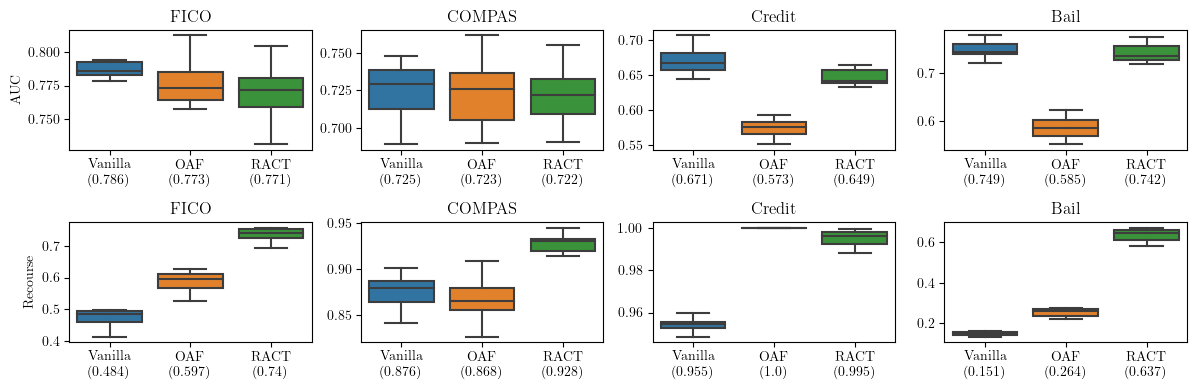

In [4]:
draw_boxplots()
plt.savefig('../fig/comparison_forest.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('../fig/comparison_forest.pdf', bbox_inches='tight', pad_inches=0.05)

In [5]:
to_latex('Time [s]')

\textbf{Dataset} & \textbf{Vanilla} & \textbf{OAF} & \textbf{RACT} \\
FICO & $42.085 \pm 1.8$ & $35.25 \pm 1.52$ & $48.074 \pm 2.33$ \\
COMPAS & $2.311 \pm 0.32$ & $1.755 \pm 0.14$ & $2.074 \pm 0.13$ \\
Credit & $292.532 \pm 21.56$ & $268.405 \pm 18.93$ & $277.398 \pm 25.75$ \\
Bail & $24.842 \pm 1.93$ & $3.262 \pm 0.35$ & $22.968 \pm 1.2$ \\


In [6]:
to_latex('Valid-Cost')

\textbf{Dataset} & \textbf{Vanilla} & \textbf{OAF} & \textbf{RACT} \\
FICO & $0.447 \pm 0.05$ & $0.407 \pm 0.03$ & $0.283 \pm 0.01$ \\
COMPAS & $0.298 \pm 0.02$ & $0.28 \pm 0.01$ & $0.232 \pm 0.02$ \\
Credit & $0.293 \pm 0.02$ & $0.0 \pm 0.0$ & $0.166 \pm 0.04$ \\
Bail & $0.763 \pm 0.03$ & $0.525 \pm 0.04$ & $0.332 \pm 0.04$ \\


In [7]:
to_latex('Plausibility')

\textbf{Dataset} & \textbf{Vanilla} & \textbf{OAF} & \textbf{RACT} \\
FICO & $0.456 \pm 0.0$ & $0.446 \pm 0.0$ & $0.437 \pm 0.0$ \\
COMPAS & $0.44 \pm 0.01$ & $0.447 \pm 0.01$ & $0.453 \pm 0.01$ \\
Credit & $0.526 \pm 0.01$ & $0.0 \pm 0.0$ & $0.523 \pm 0.01$ \\
Bail & $0.504 \pm 0.01$ & $0.507 \pm 0.0$ & $0.512 \pm 0.01$ \\


In [8]:
to_latex('Budget-Validity', causal=True)

\textbf{Dataset} & \textbf{Vanilla} & \textbf{OAF} & \textbf{RACT} \\
FICO & $0.316 \pm 0.04$ & $0.502 \pm 0.03$ & $0.648 \pm 0.03$ \\
COMPAS & $0.599 \pm 0.02$ & $0.642 \pm 0.04$ & $0.721 \pm 0.02$ \\
Credit & $0.669 \pm 0.05$ & $1.0 \pm 0.0$ & $0.964 \pm 0.03$ \\
Bail & $0.174 \pm 0.04$ & $0.201 \pm 0.04$ & $0.649 \pm 0.03$ \\


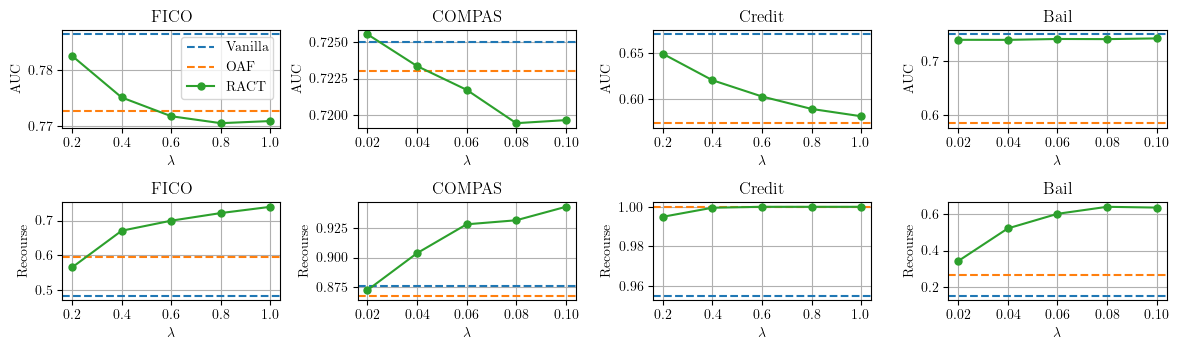

In [9]:
draw_sensitivities()
plt.savefig('../fig/tradeoff_forest.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('../fig/tradeoff_forest.pdf', bbox_inches='tight', pad_inches=0.05)

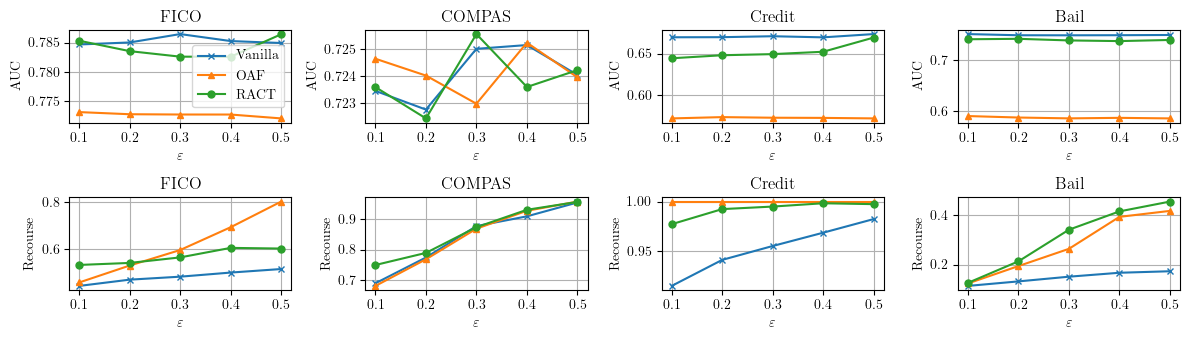

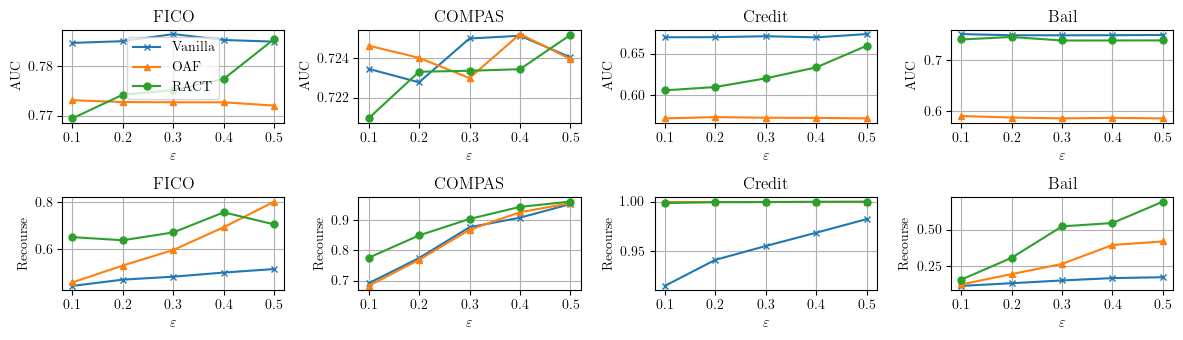

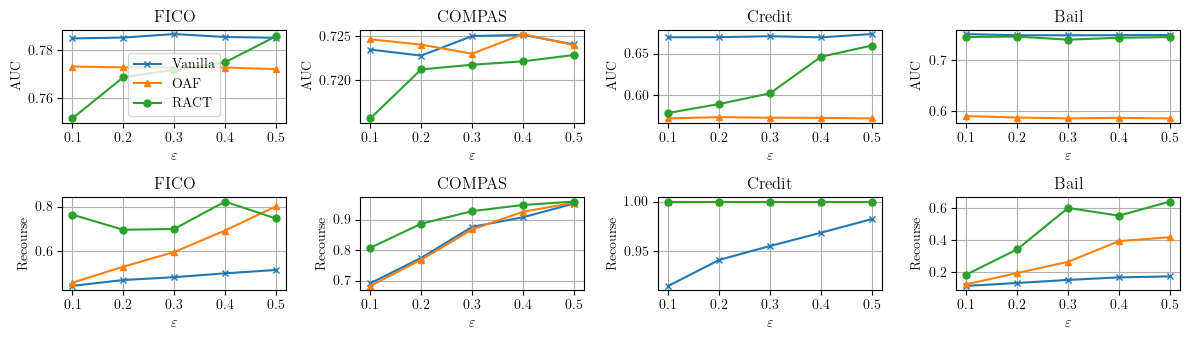

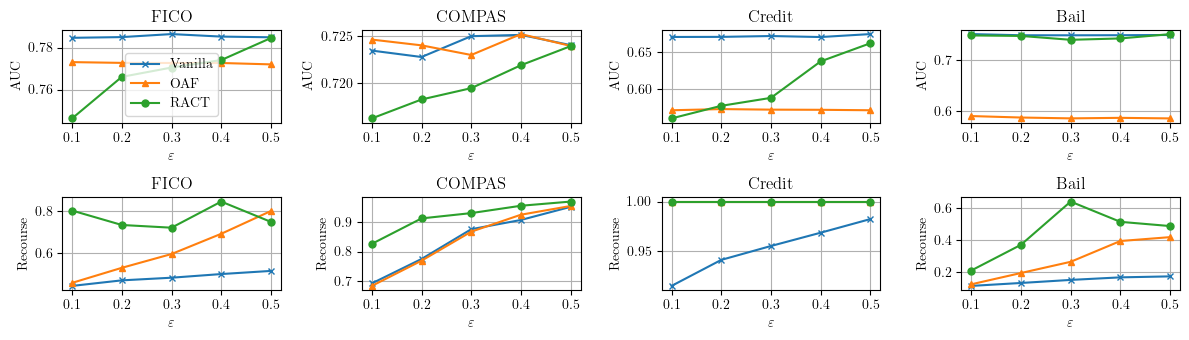

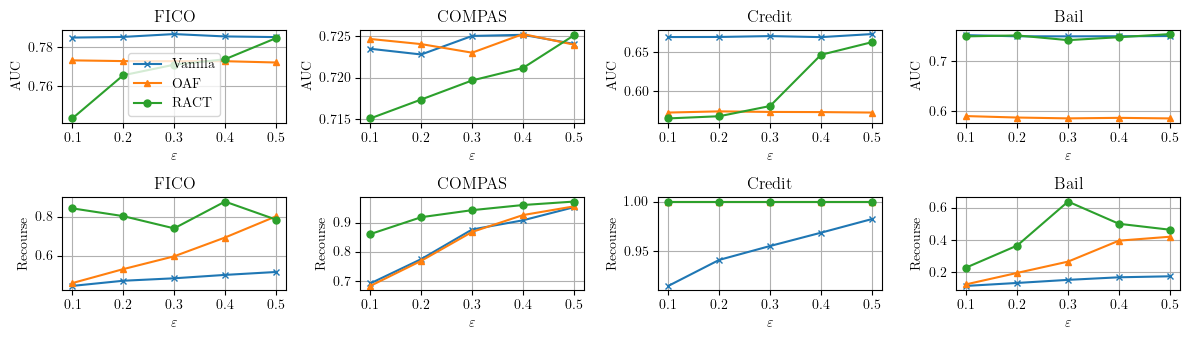

In [10]:
for alpha in [1, 2, 3, 4, 5]:
    draw_budget_sensitivities(alpha)
    plt.savefig('../fig/appendix/sensitivity_forest_{}.png'.format(alpha), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('../fig/appendix/sensitivity_forest_{}.pdf'.format(alpha), bbox_inches='tight', pad_inches=0.05)

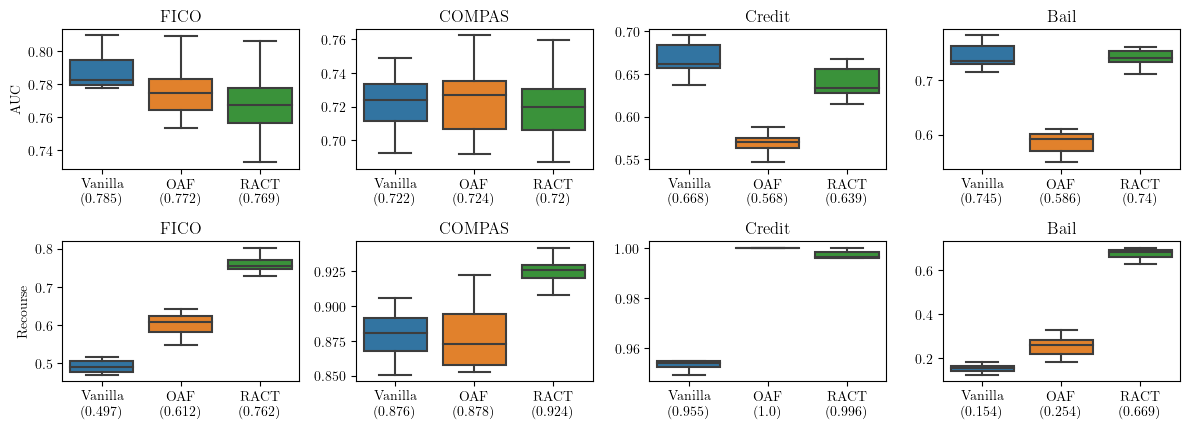

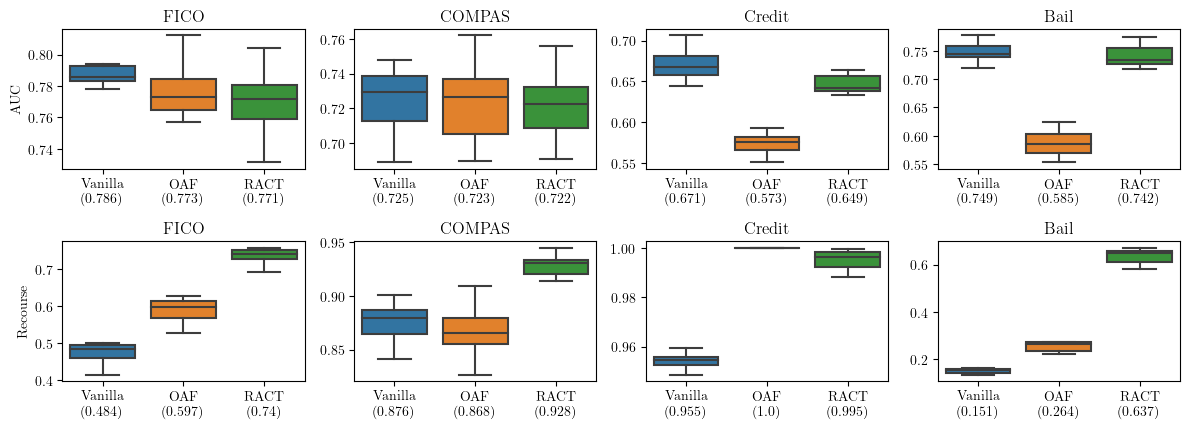

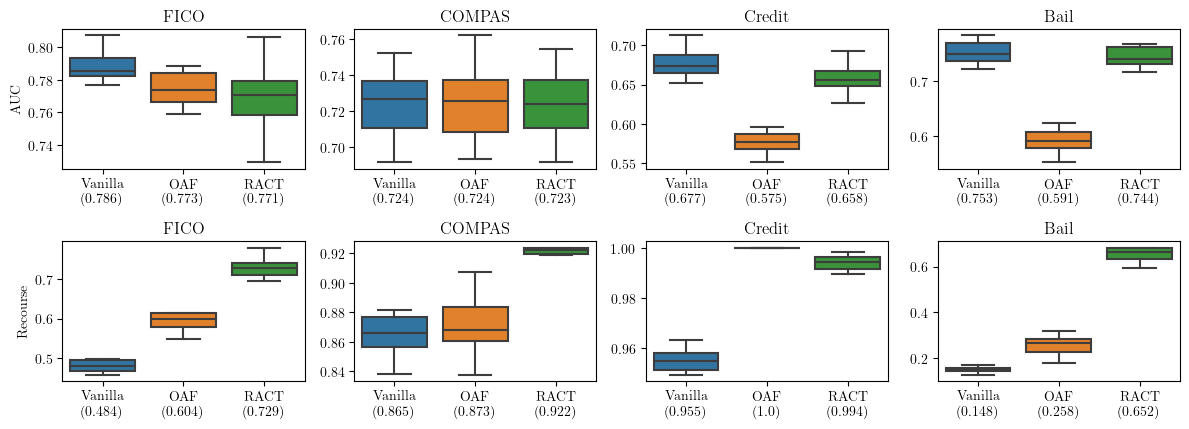

In [11]:
for n_estimators in [100, 200, 400]:
    draw_complexity_boxplots(n_estimators)
    plt.savefig('../fig/appendix/complexity_comparison_forest_{}.png'.format(n_estimators), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('../fig/appendix/complexity_comparison_forest_{}.pdf'.format(n_estimators), bbox_inches='tight', pad_inches=0.05)

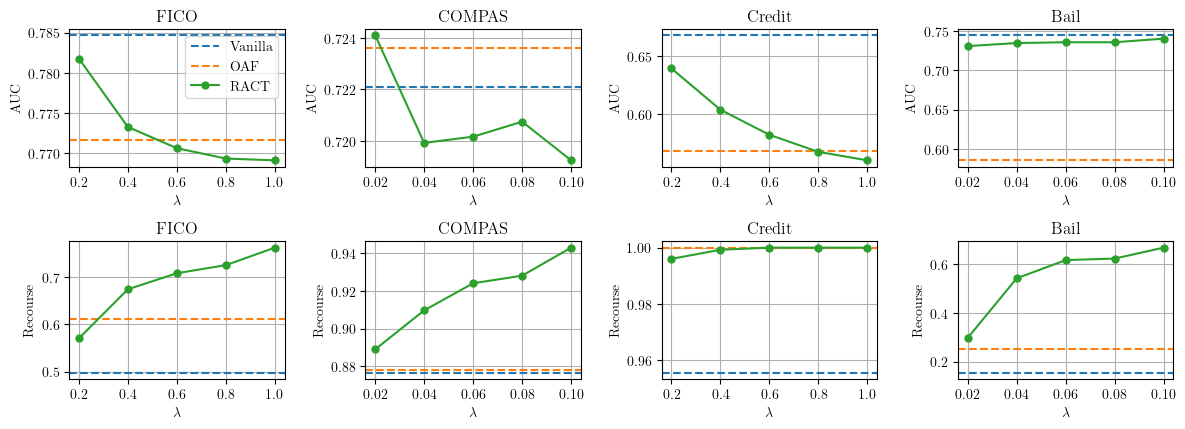

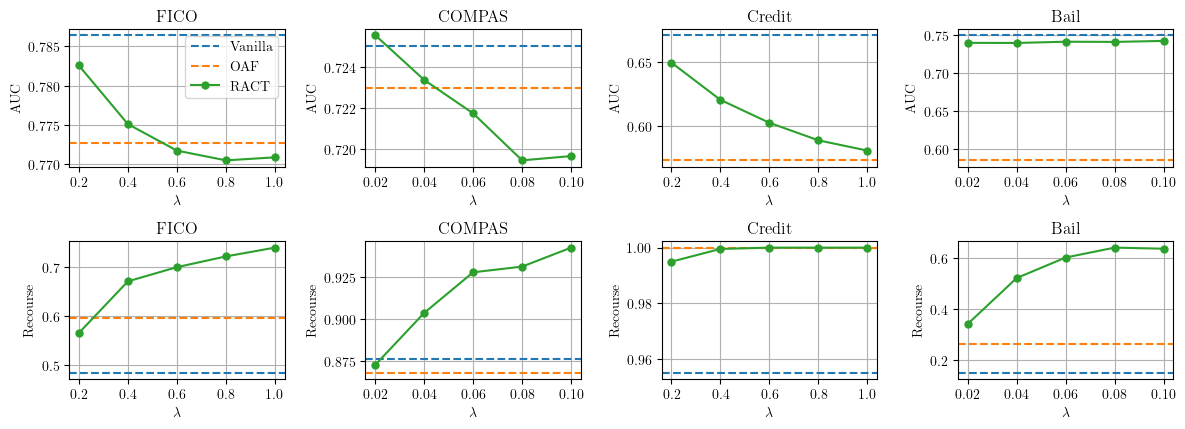

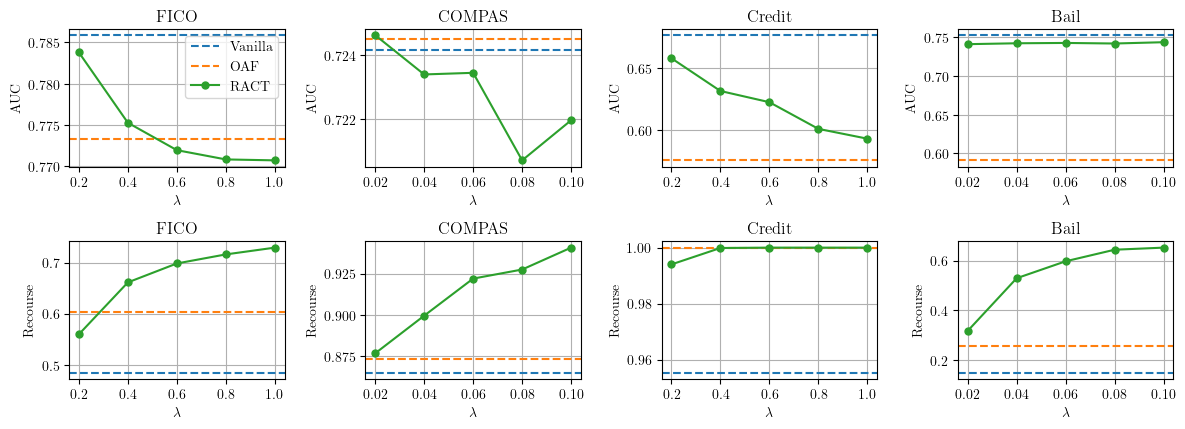

In [12]:
for n_estimators in [100, 200, 400]:
    draw_complexity_sensitivities(n_estimators)
    plt.savefig('../fig/appendix/complexity_tradeoff_forest_{}.png'.format(n_estimators), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('../fig/appendix/complexity_tradeoff_forest_{}.pdf'.format(n_estimators), bbox_inches='tight', pad_inches=0.05)

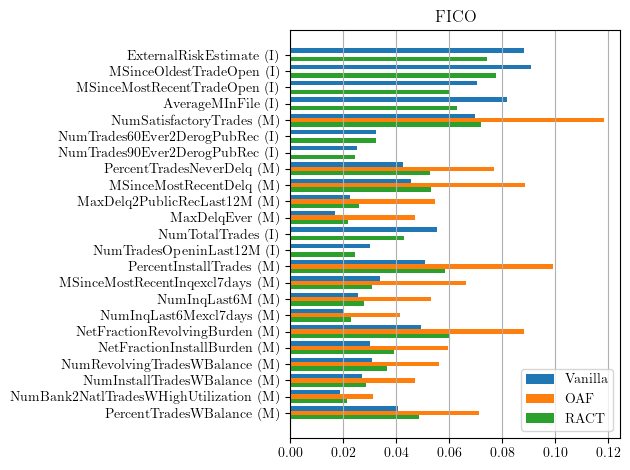

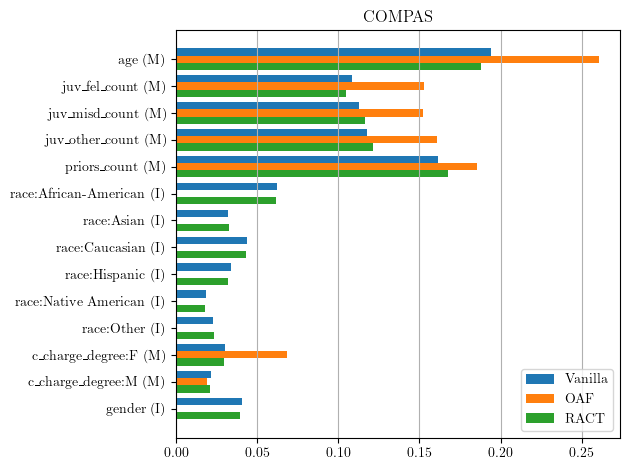

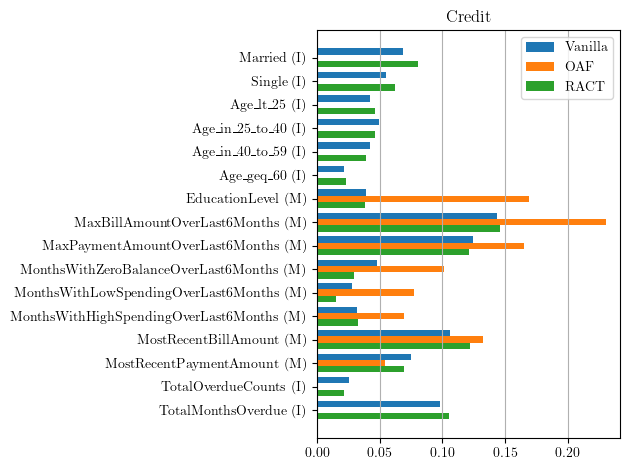

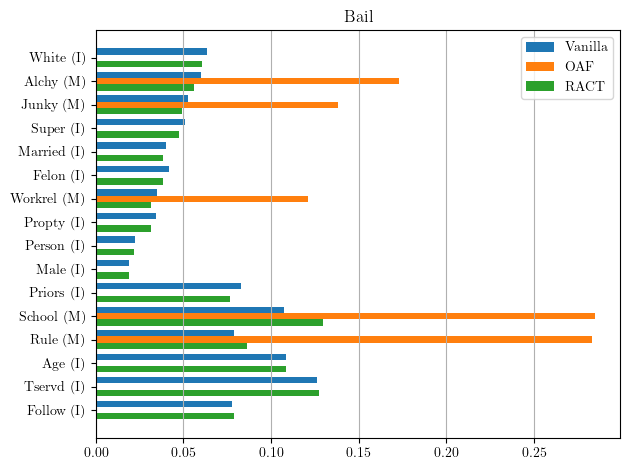

In [13]:
for dataset in DATASETS:
    plot_importance(dataset)
    plt.savefig('../fig/appendix/importance_forest_{}.png'.format(dataset), bbox_inches='tight', pad_inches=0.05)
    plt.savefig('../fig/appendix/importance_forest_{}.pdf'.format(dataset), bbox_inches='tight', pad_inches=0.05)    